In [1]:
import numpy as np
from hipposlam.utils import read_pickle
from hipposlam.sequences import Sequences
from hipposlam.comput_utils import circular_gau_filter, divide_ignore, midedges, Arena
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import os
import matplotlib as mpl
from matplotlib import cm
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy.special import factorial
# Paths and data===============
debug_plot_tag = True
project_tag = 'Avoidance_CloseObjs_theta1024'
data_dir = join('data', project_tag)
plot_dir = join('plots', project_tag, 'BayesianDecoding')
os.makedirs(plot_dir, exist_ok=True)
trajdata = read_pickle(join(data_dir, 'traj.pickle'))
metadata = read_pickle(join(data_dir, 'meta.pickle'))
seqR = metadata['seqR']
seqL = metadata['seqL']
fkey2id_dict = metadata['stored_f']
id2fkey_dict = {val:key for key, val in fkey2id_dict.items()}
f_pos = metadata['fpos']
trajdf = pd.DataFrame(trajdata)
trajdf['X_Nrow'] = trajdf['X'].apply(lambda x : x.shape[0])
trajdf['a'] = trajdf['rota'] * trajdf['rotz']

In [2]:
class MatrixJ:

    def __init__(self, N, F, K):
        self.mat = np.zeros((N, F, K))


    def expand_F(self, num:int):
        if num > 0:
            mat_to_append = np.zeros((self.mat.shape[0], num, self.mat.shape[2]))
            self.mat = np.append(self.mat, mat_to_append, axis=1)
        return self.mat.shape[1]

    def expand_N(self, num:int):
        if num > 0:
            mat_to_append = np.zeros((num, self.mat.shape[1], self.mat.shape[2]))
            self.mat = np.append(self.mat, mat_to_append, axis=0)
        return self.mat.shape[0]

    def increment(self, X, target_n:int):

        assert (X.shape[0] == self.mat.shape[1])  # same F
        assert (X.shape[1] == self.mat.shape[2])  # same K
        self.mat[target_n, :, :] = self.mat[target_n, :, :] + X

    def normalize(self):
        N, F, K = self.mat.shape
        assert N > 0
        assert F > 0
        areas = np.sqrt(np.sum(np.sum(self.mat ** 2, axis=1), axis=1))
        # areas = np.sum(np.sum(self.mat, axis=1), axis=1)
        self.mat = self.mat / areas.reshape(areas.shape[0], 1, 1)



In [17]:
class HippoLearner:
    def __init__(self, R, L, NL):
        self.K = R + L - 1  # Number of columns of J

        self.current_F = 0
        self.previous_F = 0  # Number of feature nodes when the learning started
        self.N = 0  # Number of state nodes
        self.J = MatrixJ(self.N, self.current_F, self.K)  # MatrixJ mapping J.reshape(N, -1) @ X.flatten() = State vector
        self.learn_mode = False
        self.NL = NL  #  Number of learning steps.
        self.learn_l = 0  # the l-th learning step
        self.learn_S = 0
        self.current_S = 0
        self.current_Sval = 1

    def step(self, X):
        """

        Parameters
        ----------
        X : ndarray
            2-d array with shape (F, K). F = Number of feature nodes. K = R + L - 1.

        Returns
        -------

        """
        newF = X.shape[0]
        # Conditions trigger learning
        if (newF > self.current_F) or ((self.current_Sval < 0.9) and X.sum() > 1):
            if  (self.learn_l == 0) and (self.learn_mode==False) :
                self.learn_mode = True
                # Create a new state node
                self.N = self.J.expand_N(1)

        # Once learning is triggered
        if self.learn_mode:
            # Extend self.J.mat to the shape of X
            dF = newF - self.J.mat.shape[1]
            self.current_F = self.J.expand_F(dF)

            # Associate X and J to N-th node
            self.J.increment(X, self.N-1)

            self.learn_l += 1
            self.learn_S = self.N-1

            if self.learn_l == (self.NL-1):
                self.J.normalize()
                self.learn_l = 0
                self.learn_mode = False


    def infer_state(self, X):
        if self.learn_mode:
            self.current_S = self.learn_S
            Snodes = np.zeros(self.N)
            Snodes[self.current_S] = 1
            self.current_Sval = 1

        else:

            if X.sum() < 1e-6:
                # if No feature nodes were observed, use the previous state as inferred result
                Snodes = np.zeros(self.N)
                Snodes[self.current_S] = 1
                self.current_Sval = 1

            else:
                Snodes = self.J.mat.reshape(self.N, self.current_F * self.K) @ X.flatten()
                self.current_S = np.argmax(Snodes)
                self.current_Sval = np.max(Snodes)

        return self.current_S, Snodes






In [18]:
HL = HippoLearner(R=seqR, L=seqL, NL=10)

s = [0]
alls_list = [np.array([1])]
for i in range(trajdf.shape[0]):
    if i == 0:
        continue

    X = trajdf['X'][i]
    HL.step(X)
    sid, snodes = HL.infer_state(X)

    s.append(sid)
    alls_list.append(snodes)

s = np.array(s)

slens = [len(snodes) for snodes in alls_list]

svecs = np.zeros((len(alls_list), np.max(slens)))

for i in range(len(alls_list)):
    snodes = alls_list[i]
    svecs[i, :slens[i]] = snodes


In [19]:
svecs

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

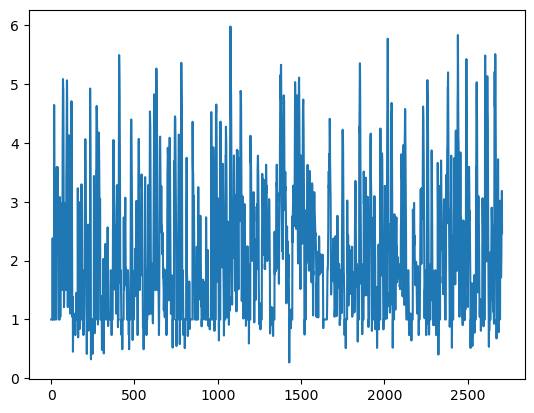

In [20]:
svecmaxs = svecs.max(axis=1)

plt.plot(svecmaxs)

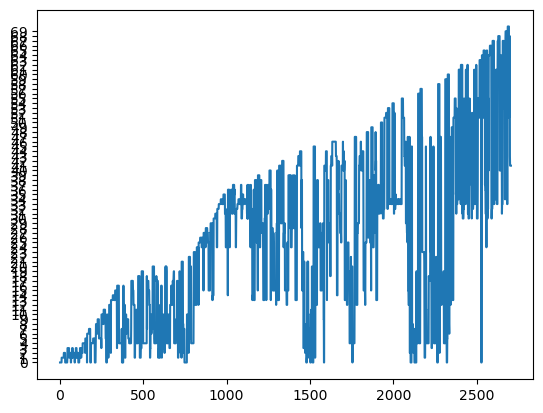

In [21]:
plt.plot(s)
_ = plt.yticks(np.arange(np.max(s)))

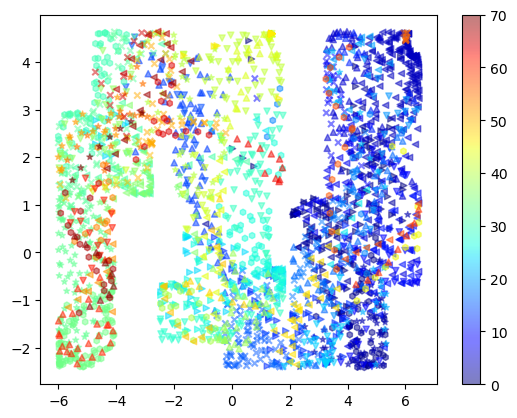

In [22]:
allmarkers = ['v', '^', '<', ">", "x", 'h', "*"]
x = trajdf['x'].to_numpy()
y = trajdf['y'].to_numpy()
a = trajdf['a'].to_numpy()
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
smin, smax = s.min(), s.max()
r = 2
fig, ax = plt.subplots()
unis = np.unique(s)
for i in range(len(unis)):
    seach = unis[i]
    mask = s == seach
    markerid = np.random.randint(0, len(allmarkers))

    im = ax.scatter(x[mask], y[mask], c=s[mask], cmap='jet', marker=allmarkers[markerid], alpha=0.5, s=20, vmin=smin, vmax=smax)
plt.colorbar(im, ax=ax)


C:\Users\yyhho\AppData\Local\Temp\ipykernel_9636\4237579590.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


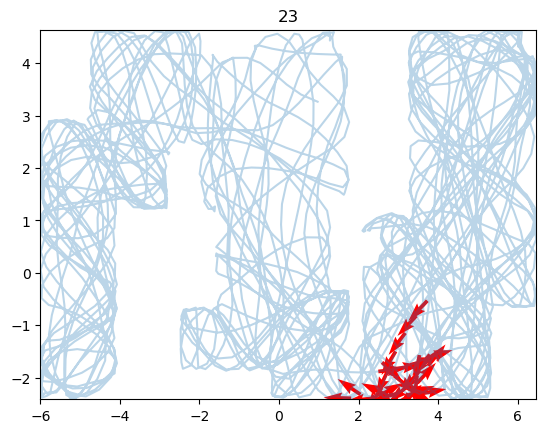

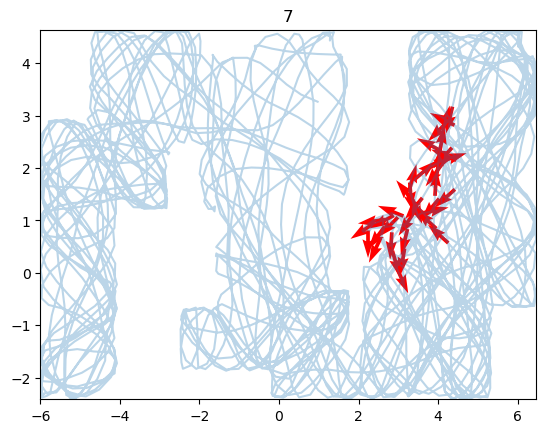

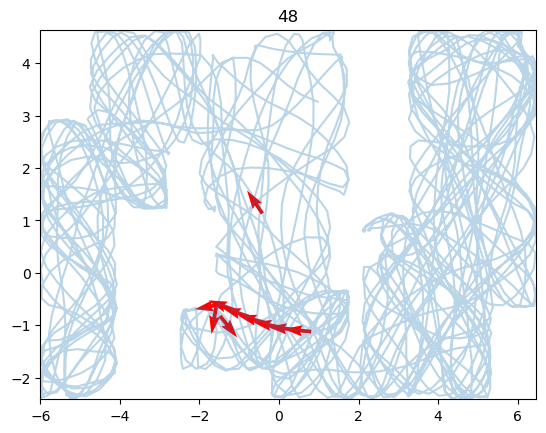

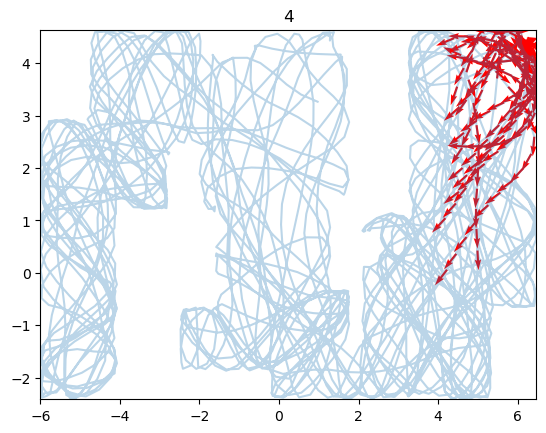

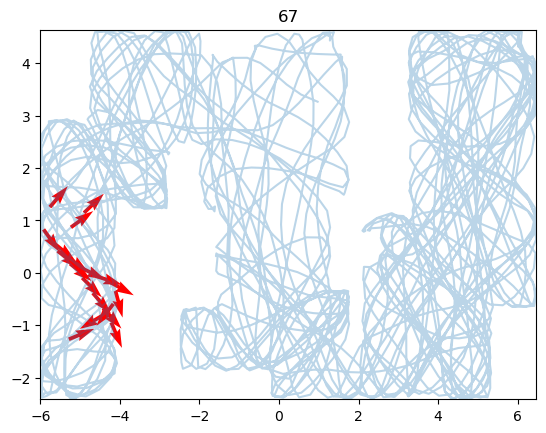

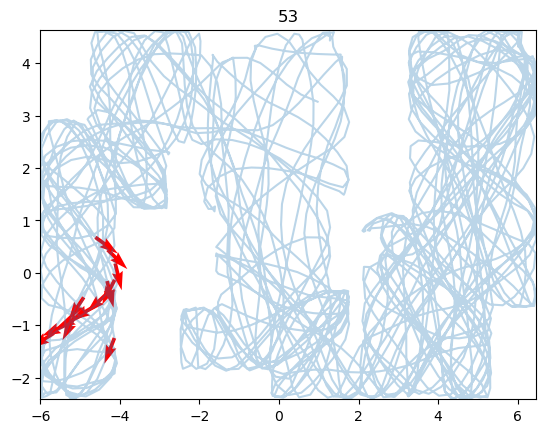

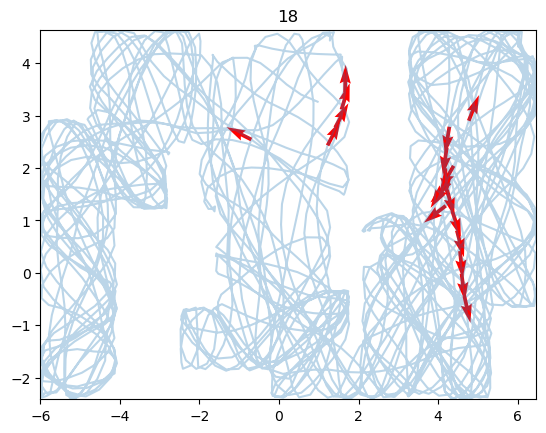

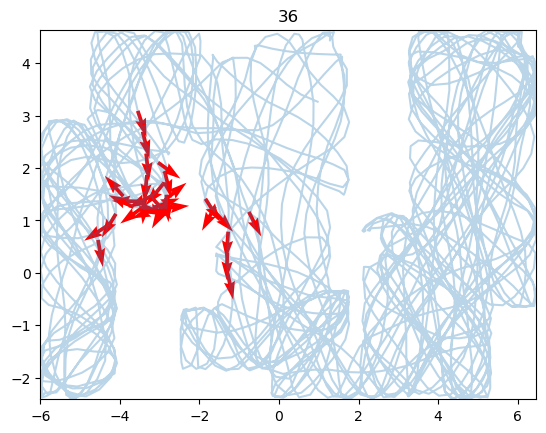

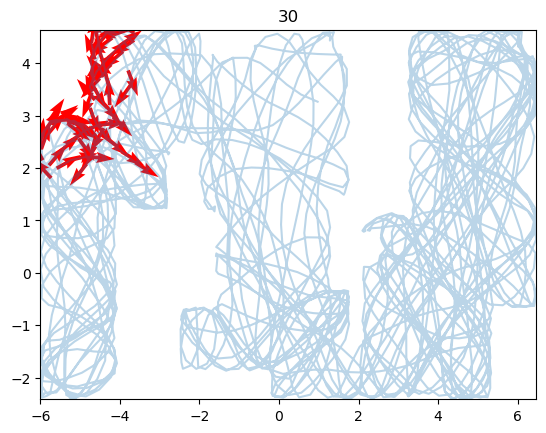

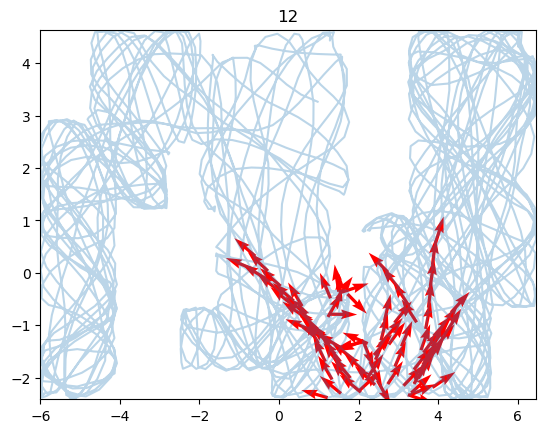

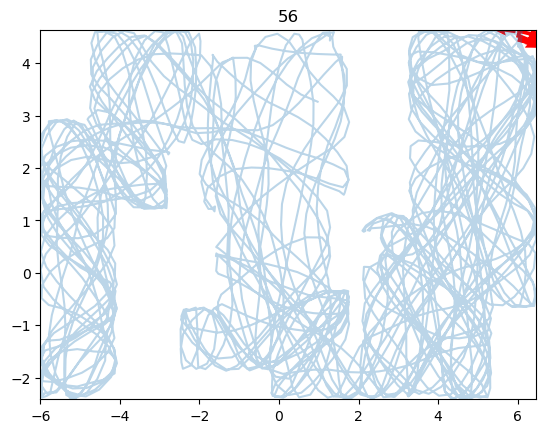

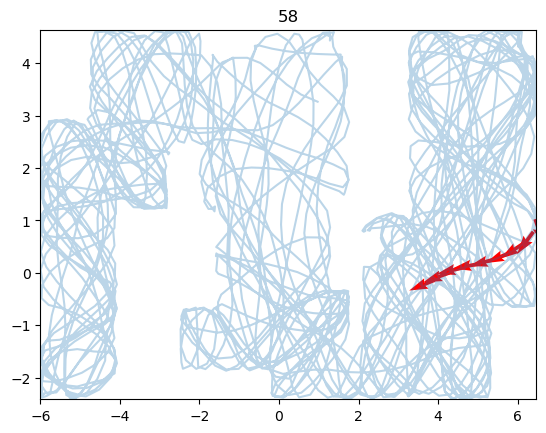

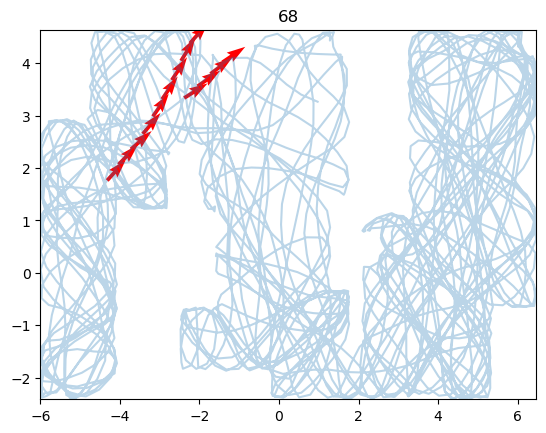

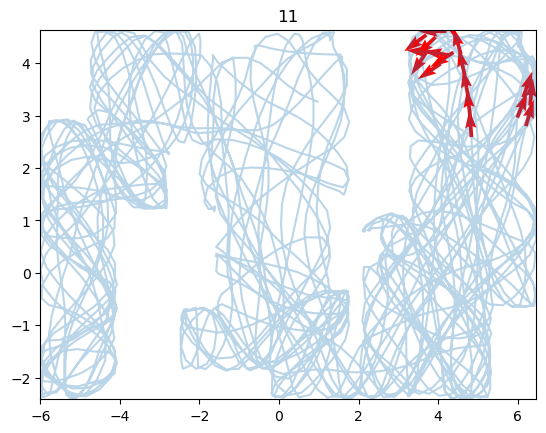

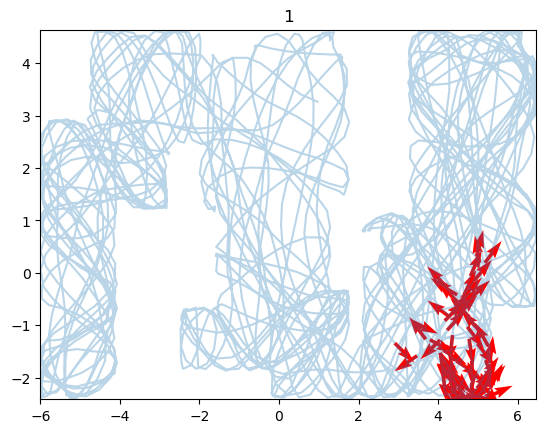

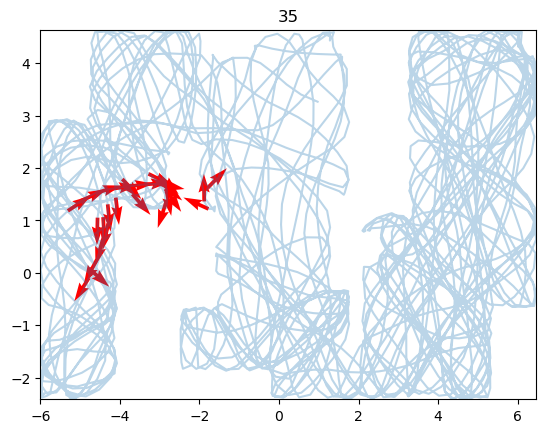

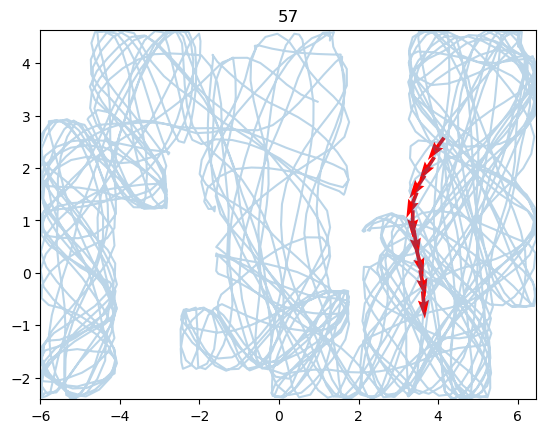

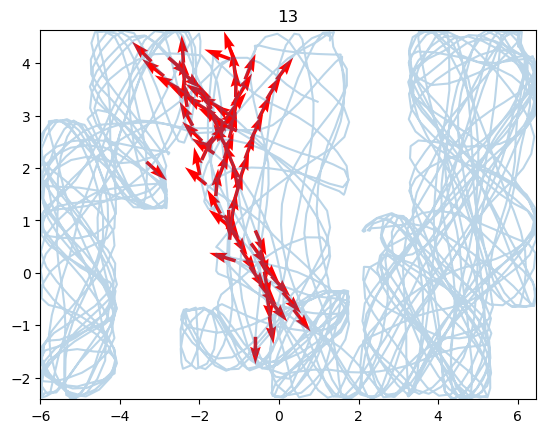

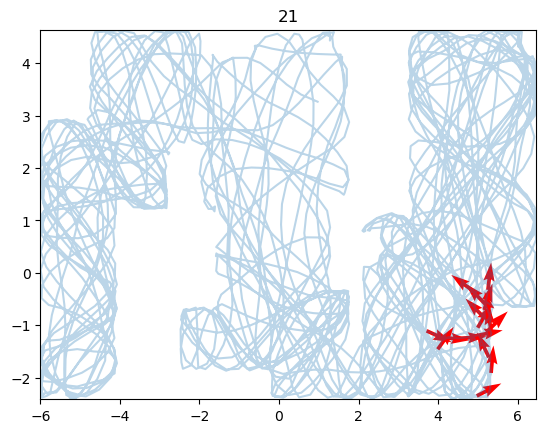

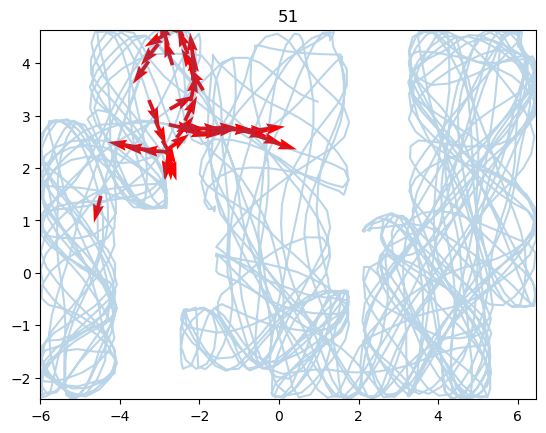

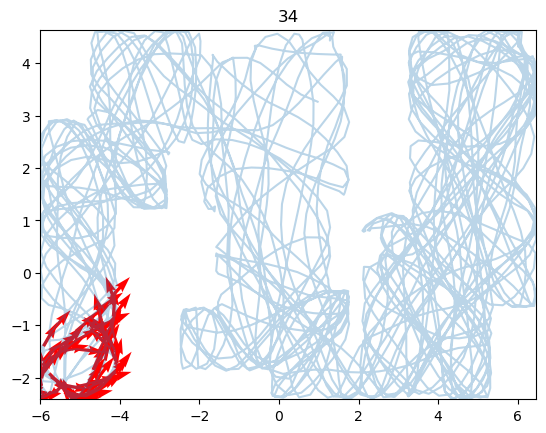

In [24]:
r = 2

x = trajdf['x'].to_numpy()
y = trajdf['y'].to_numpy()
a = trajdf['a'].to_numpy()
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
unis = np.unique(s)
unis_rand = unis[np.random.permutation(unis.shape[0])]
for i in range(len(unis)):
    if i > 20:
        break
    seach = unis_rand[i]
    mask = s == seach

    fig, ax = plt.subplots()
    ax.plot(x, y, alpha=0.3)
    ax.quiver(x[mask], y[mask], r*np.cos(a[mask]), r*np.sin(a[mask]), color='r')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(seach)
